# Evaluation Of Different Models

## Notebook Overview: Evaluation of Shortlisted Models

### Shortlisted Models
The following models were shortlisted for evaluation in our task:

- **Meta LLaMA 3.2 1B**
- **Gemini Pro**
- **Gemini model fine-tuned for the specific task**
- **Mixtral 7B**

### Evaluation Criteria

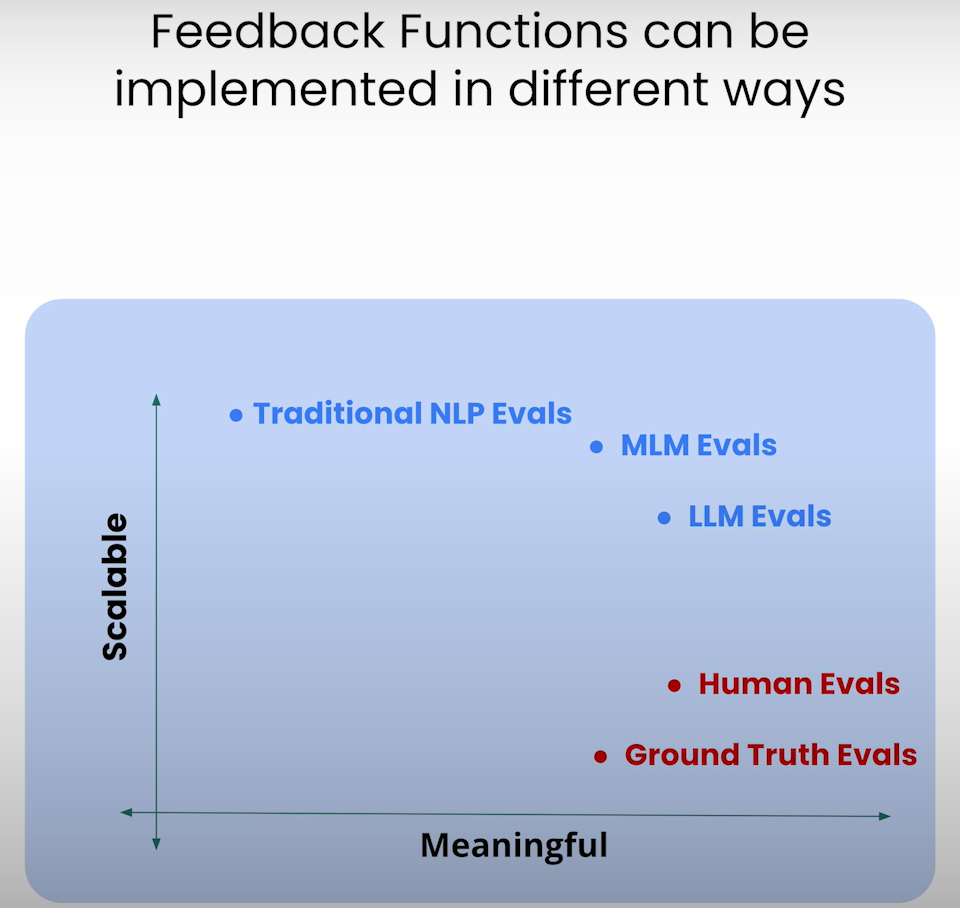

Since LLM-based evaluations are easier to implement in our scenario, we decided to proceed with the **RAG Triad** evaluation framework.

The evaluation is based on a framework known as the **RAG Triad**.

### **RAG Triad**
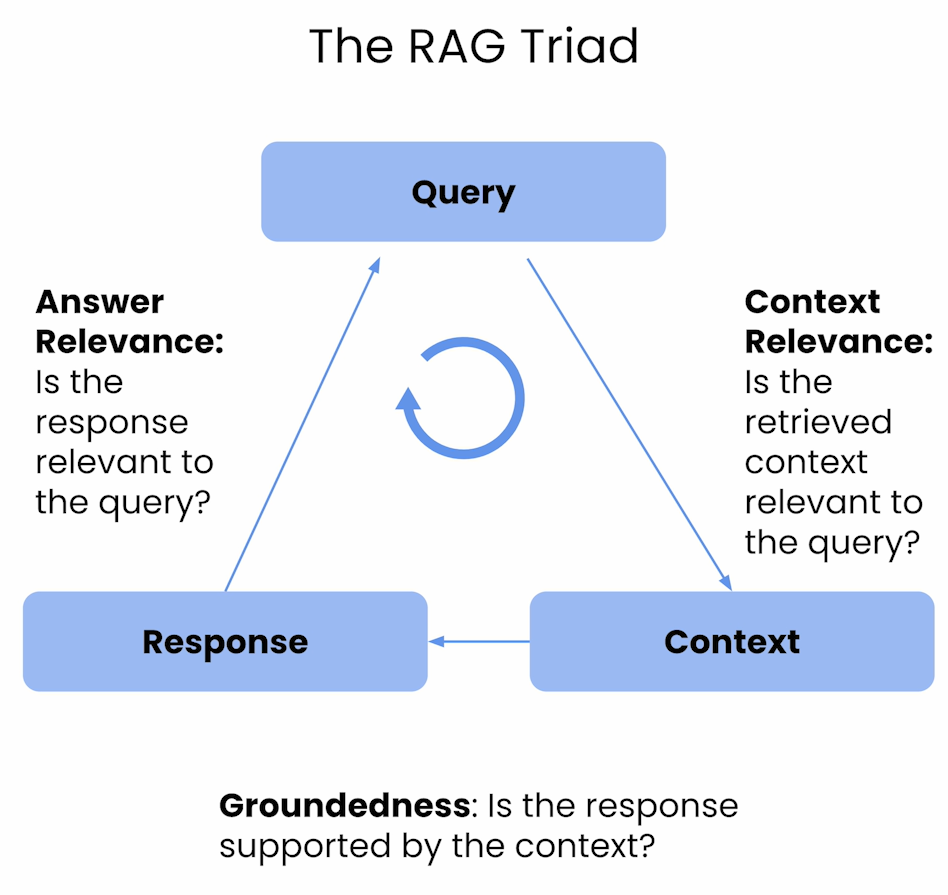


The “RAG Triad,” introduced by Truera, is an evaluation framework to assess Language Model Model (LLM) responses for reliability and contextual integrity. It combines three evaluations: Context Relevance, Groundedness, and Answer Relevance. These evaluations help detect hallucinations in LLM responses by ensuring that context is relevant, responses are grounded, and answers align with user queries. RAG Triad enhances AI applications by delivering accurate and trustworthy interactions between humans and machines. 
The RAG Triad combines three key evaluations:

1. **Context Relevance**  
   Evaluates how well the retrieved context aligns with the user's query. This is typically assessed by prompting an LLM to compare the query and context.
   
2. **Groundedness**  
   Assesses whether the response is firmly based on the provided context, ensuring that the answer is grounded in factual information from the retrieved content.

3. **Answer Relevance**  
   Goes beyond groundedness to ensure that the final response generated by the LLM effectively addresses the user's query, making the answer pertinent and helpful.

These three evaluations combined help detect hallucinations in LLM responses, improving reliability by ensuring that:
- The context is relevant to the user’s query.
- The response is grounded in that context.
- The final answer is relevant and useful to the user’s question.

Although the RAG Triad may not be 100% effective at detecting hallucinations, it remains a strong measure for this purpose. For more information, see the official page: 
[Truera - RAG Triad](https://truera.com/ai-quality-education/generative-ai-rags/what-is-the-rag-triad/).

### Evaluation Process followed

1. **General User Questions:**  
   Common questions are generated or sourced from user interactions.

2. **Model Selection:**  
   Each shortlisted model is evaluated.

3. **Context Retrieval:**  
   Using Langchain, the top 3 relevant context chunks are retrieved from the **Pinecone vector store** based on the user’s query.

4. **Answer Generation:**  
   The retrieved context is fed into the model along with a specific prompt, and an answer is generated.

5. **Evaluation of Responses:**  
   The evaluation process assesses each model's response using the following criteria:
   - **Groundedness**
   - **Answer Relevance**
   - **Faithfulness** (to assess how closely the answer sticks to the facts)

   A specific prompt is used to ask the **Gemini model** to evaluate the generated response (as Gemini is fast and reliable). The model gives a score between 0 and 1 for each criterion, along with an explanation of its reasoning (chain of thought).

6. **Results Storage:**  
   The questions, retrieved contexts, generated answers, and evaluation scores are added to a table and saved in a CSV file for further analysis.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#all the important keys
hf_token=""
gemini_api_key=""
pinecone_api_key = ""
groq_api_key = ""

In [4]:
#all the imports
!pip install langchain
!pip install langchain-core
!pip install langchain-community
!pip install langchain-pinecone
!pip install sentence-transformers
!pip install groq
!pip install transformers
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: requests-toolbelt
    Found existing installation: requests-toolbelt 0.10.1
    Uninstalling requests-toolbelt-0.10.1:
      Successfully uninstalled requests-toolbelt-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cud

# Setting up the Existing Vector Store

In [5]:
#vector store initialization
from pinecone import Pinecone, ServerlessSpec
import time
# from config import VECTOR_DIMENSION
VECTOR_DIMENSION = 384 # 768 do if nomic embeddings using
class PineconeManager:
    def __init__(self, api_key: str, index_name: str):
        self.pc = Pinecone(api_key=api_key)
        self.index_name = index_name
        self.index = None
        self.initialize_index() #to initialize the index
    def initialize_index(self):
        if self.index_name not in self.pc.list_indexes().names():#shd use list indexes here
            print(f"Creating index: {self.index_name}")
            self.pc.create_index(
                name=self.index_name,
                dimension=VECTOR_DIMENSION,
                metric="cosine",
                spec=ServerlessSpec(
                    cloud="aws",
                    region="us-east-1"
                )
            )
        else:
            print(f"Index {self.index_name} already exists")

        while not self.pc.describe_index(self.index_name).status['ready']:
            time.sleep(1)

        self.index = self.pc.Index(self.index_name)


In [6]:
from langchain_pinecone import PineconeVectorStore
INDEX_NAME = 'dlprojectchecknomic'
pinecone_manager = PineconeManager(pinecone_api_key, INDEX_NAME)
pinecone_manager.initialize_index()

Index dlprojectchecknomic already exists
Index dlprojectchecknomic already exists


# Questions to test

In [10]:
#questions to evaluate the model
questions =[
    "Can you explain what a Bidirectional LSTM layer is in Keras?",
    "How do I use the Keras Sequential model for building neural networks?",
    "What are the key differences between the Dense and Conv2D layers in Keras?",
    "How do you implement dropout in a Keras model to prevent overfitting?",
    "Explain me why and how to use the EarlyStopping callback in Keras",
    "Explain me how to build a LSTM model in Keras",
    "How to use the ResNet model from keras applications for image classification?",
    "Explain me the parameters used in the Conv2D layer in Keras",
    "Explain me about the MNIST digits classification dataset",
    "What is the purpose of using the Embedding layer in Keras?",
    "Give me code for loading images using ImageDataGenerator in Keras",
    "How do you perform transfer learning using a pre-trained model in Keras?",
    "Can you explain how to save and load a Keras model?",
    "What are some common activation functions in Keras, and when should I use each?"
]

# Testing gemini model

In [8]:
#setting up the gemini model
import google.generativeai as genai
genai.configure(api_key=gemini_api_key)

In [9]:
#setting the embeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = PineconeVectorStore(index=pinecone_manager.index, embedding=embeddings)

/tmp/ipykernel_30/2008718675.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Setting up the retriever and rag prompt

In [20]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
rag_prompt = """You are an intelligent assistant designed to provide accurate and relevant information from Keras documentation.

        Here is the retrieved context, which may contain both explanatory text and meaningful code snippets:

        {context}

        Carefully analyze the above context, considering both the text and any provided code for clarity.

        Now, review the user's query:

        {question}

        Generate a detailed response that accurately addresses the query using the provided context. If the context includes relevant code, incorporate it into your response. Ensure that your answer is both clear and grounded in the provided content.

        Response:
        """

In [25]:
#using the RAG Triad for evaulating the model
#RAG TRIAD
# -> answer relevance,context relevance,groundedness
import google.generativeai as genai
import time
from random import uniform
model = genai.GenerativeModel("gemini-pro")#using the gemini model
# Groundedness prompt
groundedness_prompt = """You are an AI grader evaluating the groundedness of an answer based on given facts. 

FACTS: {documents}

ANSWER TO EVALUATE: {generation}

Grade the answer based on these criteria:
1. The answer is grounded in the provided facts.
2. The answer does not contain "hallucinated" information outside the scope of the facts.

Explain your reasoning step-by-step. Then, provide a final score between 0 and 1, where:
0 = The answer completely fails to meet the criteria
1 = The answer fully meets all criteria

Your response should be in this format:
Reasoning: [Your step-by-step explanation]
Score: [Your score between 0 and 1]
Explanation: [A brief summary of why you gave this score]
"""

# Answer relevance prompt
answer_relevance_prompt = """You are an AI grader evaluating the relevance of an answer to a given question.

QUESTION: {question}

ANSWER TO EVALUATE: {generation}

Grade the answer based on this criterion:
1. The answer helps to answer the question (it can contain extra relevant information)

Explain your reasoning step-by-step. Then, provide a final score between 0 and 1, where:
0 = The answer is completely irrelevant to the question
1 = The answer is highly relevant and fully addresses the question

Your response should be in this format:
Reasoning: [Your step-by-step explanation]
Score: [Your score between 0 and 1]
Explanation: [A brief summary of why you gave this score]
"""

# Context relevance prompt
context_relevance_prompt = """You are an AI grader evaluating whether a given context contains enough information to answer a question.

QUESTION: {question}

CONTEXT TO EVALUATE: {context}

Grade the context based on this criterion:
1. The context contains enough information to answer the question (it can contain extra relevant information)

Explain your reasoning step-by-step. Then, provide a final score between 0 and 1, where:
0 = The context contains no relevant information to answer the question
1 = The context contains all necessary information to fully answer the question

Your response should be in this format:
Reasoning: [Your step-by-step explanation]
Score: [Your score between 0 and 1]
Explanation: [A brief summary of why you gave this score]
"""

def grade_response(prompt_template, **kwargs):
    prompt = prompt_template.format(**kwargs)
    result = model.generate_content(prompt)
    return result.text

In [26]:
#function to extract the score from the result
def extract_score(result_text):
    for line in result_text.split('\n'):
        if line.startswith('Score:'):
            return float(line.split(':')[1].strip())
    return None

In [27]:
#function to evaluate using the rag triad
def evaluate_gemini_using_rag_traid_with_gemini(model, retriever, rag_prompt, questions,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt, delay_range=(1, 3)):
    results = []
    for question in questions:
        try:
            print(f"Processing question: {question}\n")

            # Retrieve context using Pinecone retriever
            print("Retrieving context...\n")
            context_from_pinecone = retriever.get_relevant_documents(question)
            context = "\n\n".join(doc.page_content for doc in context_from_pinecone)
            
            # Add random delay to avoid hitting the rate limit
            time.sleep(uniform(delay_range[0], delay_range[1]))
            
            print("Generating RAG response...\n")
            rag_prompt_formatted = rag_prompt.format(context=context, question=question)
            rag_result = model.generate_content(rag_prompt_formatted)
            rag_response = rag_result.text
            
#             print("Cleaning RAG response...\n")
#             cleaned_response = rigorous_clean_response(rag_response)
            
            time.sleep(uniform(delay_range[0], delay_range[1]))
            
            print("Starting the evaluation...\n")
            
            print("Evaluating answer relevancy...\n")
            answer_relevancy_score = grade_response(
                answer_relevance_prompt,
                question=question,
                generation=rag_response
            )
            
            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating context relevancy...\n")
            context_relevancy_score = grade_response(
                context_relevance_prompt,
                question=question,
                context=context
            )
            
            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating faithfulness...\n")
            faithfulness_score = grade_response(
                groundedness_prompt,
                documents=context,
                generation=rag_response
            )
            
            print("Done! Adding to results\n")
            results.append({
                "question": question,
                "context": context,
                "rag_response": rag_response,
                "answer_relevancy": answer_relevancy_score,
                "context_relevancy": context_relevancy_score,
                "faithfulness": faithfulness_score,
                "answer_relevancy_score": extract_score(answer_relevancy_score),
                "context_relevancy_score": extract_score(context_relevancy_score),
                "groundedness_score": extract_score(faithfulness_score)
            })
            
            print("Done! \n")
        except Exception as e:
            print(f"Error processing question: {question}")
            print(e)

    return results

In [29]:
#testing on only one question now
question = [
    "Can you explain what a Bidirectional LSTM layer is in Keras?"
]

results = evaluate_gemini_using_rag_traid_with_gemini(model, retriever, rag_prompt, question,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt,delay_range=(1, 3))

Processing question: Can you explain what a Bidirectional LSTM layer is in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 



In [31]:
#analysing the results
results[0]['answer_relevancy']

'Reasoning:\n1. The answer directly addresses the question by providing a definition of the Bidirectional LSTM layer in Keras.\n2. The answer explains how the layer works by running the RNN layer forward and then backward, and concatenating the outputs.\n3. The answer also provides a code example and a detailed explanation of how to use the layer.\n\nScore: 1\nExplanation: The answer is highly relevant and fully addresses the question by providing a definition, explanation, and example usage of the Bidirectional LSTM layer in Keras.'

In [32]:
results[0]['faithfulness']

'**Reasoning:**\n\n1. The answer correctly states that the Bidirectional layer in Keras is a wrapper for RNNs.\n2. The answer mentions that the Bidirectional layer operates by running the RNN layer forward and then reversing the input sequence and running the same RNN layer backward, which is accurate.\n3. The answer correctly describes the output of the Bidirectional layer as having the same shape as the output of the wrapped RNN layer, but with twice the number of features.\n4. The answer accurately describes the merge_mode argument and its options.\n5. The answer provides an example of how to use the Bidirectional layer in a Keras model.\n6. The answer notes that instantiating a Bidirectional layer from an existing RNN layer instance will not reuse the weights state of the RNN layer instance, which is correct.\n\n**Score:** 1\n\n**Explanation:** The answer fully meets all criteria. It is grounded in the provided facts and does not contain any "hallucinated" information.'

In [33]:
extract_score(results[0]['answer_relevancy'])

1.0

In [34]:
#evaluating the gemini model using the rag triad
results = evaluate_gemini_using_rag_traid_with_gemini(model, retriever, rag_prompt, questions,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt,delay_range=(1, 3))

Processing question: Can you explain what a Bidirectional LSTM layer is in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do I use the Keras Sequential model for building neural networks?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: What are the key differences between the Dense and Conv2D layers in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do you implement dropout in a Keras model to prevent overfitting?

Retrieving context...

In [36]:
gemini_pro_results_df = pd.DataFrame(results)
gemini_pro_results_df

,question,context,rag_response,answer_relevancy,context_relevancy,faithfulness,answer_relevancy_score,context_relevancy_score,groundedness_score
0,Can you explain what a Bidirectional LSTM laye...,3D Convolutional LSTM.\nSimilar to an LSTM lay...,A Bidirectional LSTM layer in Keras is a wrapp...,Reasoning: \n1. The answer provides a concise ...,Reasoning: The context does not mention anythi...,**Reasoning:**\n\nStep 1: The answer mentions ...,1.0,0.0,NaN
1,How do I use the Keras Sequential model for bu...,You can create a Sequential model by passing a...,"Keras offers the Sequential model, an effectiv...",Reasoning:\n1. The answer clearly outlines the...,Reasoning: The context provides information ab...,Reasoning:\n\n1. The answer is grounded in the...,1.0,0.5,1.00
2,What are the key differences between the Dense...,2D transposed convolution layer.\nThe need for...,The provided context does not contain informat...,Reasoning:\n1. The question asks for the key d...,Reasoning: The provided context does not conta...,Reasoning: The provided text does not mention ...,0.0,0.0,1.00
3,How do you implement dropout in a Keras model ...,Applies dropout to the input.\nTheDropoutlayer...,To implement dropout in a Keras model to preve...,Reasoning:\n1. The answer provides a definitio...,Reasoning: The context explains the concept of...,Reasoning:\n\n1. The answer mentions that the ...,1.0,0.4,1.00
4,Explain me why and how to use the EarlyStoppin...,"Authors:Rick Chao, Francois CholletDate create...",**Why to use `EarlyStopping` callback?**\n\nTh...,Reasoning:\n1. The answer directly addresses t...,Reasoning: The provided context contains a bri...,Reasoning:\n1. The answer is grounded in the p...,1.0,0.5,1.00
5,Explain me how to build a LSTM model in Keras,There are three ways to create Keras models:\n...,"Sure! To build an LSTM model in Keras, begin b...",Reasoning: \n\n1. The answer directly addresse...,Reasoning: The given context provides an examp...,Reasoning:\n\n1. The answer starts by importin...,1.0,0.3,0.50
6,How to use the ResNet model from keras applica...,Instantiates the ResNet50V2 architecture.\nRef...,To use the ResNet model from Keras application...,Reasoning: The answer provides a detailed and ...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer does mention the Res...,1.0,0.0,0.75
7,Explain me the parameters used in the Conv2D l...,2D Convolutional LSTM.\nSimilar to an LSTM lay...,**Conv2D Layer Parameters in Keras**\n\nThe Co...,Reasoning:\n1. The answer starts with a brief ...,Reasoning: The provided context does not discu...,**Reasoning:**\n\n1. The answer is grounded in...,1.0,0.0,NaN
8,Explain me about the MNIST digits classificati...,Loads the MNIST dataset.\nThis is a dataset of...,"MNIST is a dataset of 70,000 grayscale images ...",Reasoning:\n\n1. The answer starts by stating ...,Reasoning: The context provides a definition a...,Reasoning:\n\n1. The answer is mostly grounded...,1.0,0.5,0.75
9,What is the purpose of using the Embedding lay...,"In the mixed dimension embedding technique, we...",The context you provided does not have informa...,Reasoning: The answer correctly identifies tha...,Reasoning: \n\n1. The provided text does not d...,Reasoning: \n1. The answer states that the pro...,1.0,0.0,1.00


In [37]:
gemini_pro_results_df.to_csv('gemini_pro_results_df.csv', index=False)

# Testing on the Finetuned Gemini Model

In [38]:
#loading the finetuned gemini model
tuned_model = genai.get_tuned_model('tunedModels/finetuninggemmafordl1-xxcubsl6ftaf')
fine_tuned_model = genai.GenerativeModel(model_name=tuned_model.name)

In [40]:
#grading of response directly from the normal gemini model
def grade_response(prompt_template, **kwargs):
    prompt = prompt_template.format(**kwargs)
    result = model.generate_content(prompt)
    return result.text

In [41]:
def tuned_model_eval_using_rag_triad_with_gemini(model, retriever, rag_prompt, questions,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt, delay_range=(1, 3)):
    results = []
    for question in questions:
        try:
            print(f"Processing question: {question}\n")

            # Retrieve context using Pinecone retriever
            print("Retrieving context...\n")
            context_from_pinecone = retriever.get_relevant_documents(question)
            context = "\n\n".join(doc.page_content for doc in context_from_pinecone)
            
            # Add random delay to avoid hitting the rate limit
            time.sleep(uniform(delay_range[0], delay_range[1]))
            
            print("Generating RAG response...\n")
            rag_prompt_formatted = rag_prompt.format(context=context, question=question)
            rag_result = model.generate_content(rag_prompt_formatted)
            rag_response = rag_result.text
            
            time.sleep(uniform(delay_range[0], delay_range[1]))
            
            print("Starting the evaluation...\n")
            
            print("Evaluating answer relevancy...\n")
            answer_relevancy_score = grade_tuned_response(
                answer_relevance_prompt,
                question=question,
                generation=rag_response
            )
            
            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating context relevancy...\n")
            context_relevancy_score = grade_tuned_response(
                context_relevance_prompt,
                question=question,
                context=context
            )
            
            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating faithfulness...\n")
            faithfulness_score = grade_tuned_response(
                groundedness_prompt,
                documents=context,
                generation=rag_response
            )
            
            print("Done! Adding to results\n")
            results.append({
                "question": question,
                "context": context,
                "rag_response": rag_response,
                "answer_relevancy": answer_relevancy_score,
                "context_relevancy": context_relevancy_score,
                "faithfulness": faithfulness_score,
                "answer_relevancy_score": extract_score(answer_relevancy_score),
                "context_relevancy_score": extract_score(context_relevancy_score),
                "groundedness_score": extract_score(faithfulness_score)
            })
            
            print("Done! \n")
        except Exception as e:
            print(f"Error processing question: {question}")
            print(e)

    return results


In [43]:
#testing on only one question now
question = [
    "Can you explain what a Bidirectional LSTM layer is in Keras?"
]

results = tuned_model_eval_using_rag_triad_with_gemini(fine_tuned_model, retriever, rag_prompt, question,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt,delay_range=(1, 3))

Processing question: Can you explain what a Bidirectional LSTM layer is in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 



In [45]:
#seeing the response
results[0]['rag_response']

'A Bidirectional LSTM layer in Keras is a special type of RNN layer that processes inputs in both forward and backward directions. This means that it effectively combines two separate LSTM layers, one running in the forward direction and the other running in the reverse direction. The outputs from these two LSTM layers are then combined according to the specified `merge_mode`. This allows the layer to capture temporal dependencies in both directions, potentially improving the model\'s ability to learn from sequential data.\n\n        Example code:\n        ```python\n        from keras.layers import Input, Bidirectional, LSTM, Dense\n        from keras.models import Sequential\n\n        model = Sequential([\n            Input(shape=(5, 10)),\n            Bidirectional(LSTM(10, return_sequences=True)),\n            Bidirectional(LSTM(10)),\n            Dense(5, activation="softmax"),\n        ])\n        model.compile(loss=\'categorical_crossentropy\', optimizer=\'rmsprop\')\n        `

In [44]:
#analysing the results
results[0]['answer_relevancy']

'Reasoning:\n1. The answer provides a clear and accurate definition of a Bidirectional LSTM layer in Keras.\n2. It explains how this layer processes inputs in both forward and backward directions, effectively combining two separate LSTM layers.\n3. The answer includes an example code snippet demonstrating how to use this layer in a neural network model.\n\nScore: 1\nExplanation: The answer is highly relevant and fully addresses the question by providing a comprehensive explanation and an example code snippet. It demonstrates a clear understanding of the topic.'

In [47]:
results[0]['faithfulness']

'Reasoning:\n1. The answer correctly describes the purpose of a Bidirectional LSTM layer in Keras, which is to process inputs in both forward and backward directions. This is grounded in the fact that "Bidirectional wrapper for RNNs" is mentioned in the facts.\n2. The answer provides an example code snippet that demonstrates how to use the Bidirectional layer with LSTM layers. This is also supported by the fact that "Example code" is mentioned in the facts.\n3. The answer does not include any information outside the scope of the provided facts.\n\nScore: 1\nExplanation: The answer fully meets all criteria by providing accurate and relevant information without hallucinating additional facts. It demonstrates a clear understanding of how to use the Bidirectional layer in Keras.'

In [48]:
extract_score(results[0]['answer_relevancy'])

1.0

In [50]:
#evaluating the tuned model with all the questions using rag triad
results = tuned_model_eval_using_rag_triad_with_gemini(fine_tuned_model, retriever, rag_prompt, questions,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt,delay_range=(1, 3))

Processing question: Can you explain what a Bidirectional LSTM layer is in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do I use the Keras Sequential model for building neural networks?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: What are the key differences between the Dense and Conv2D layers in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Error processing question: What are the key differences between the Dense and Conv2D layers in Keras?
500 An internal error has occurred. Please r

In [51]:
gemini_fine_tuned_results_df = pd.DataFrame(results)
gemini_fine_tuned_results_df

,question,context,rag_response,answer_relevancy,context_relevancy,faithfulness,answer_relevancy_score,context_relevancy_score,groundedness_score
0,Can you explain what a Bidirectional LSTM laye...,3D Convolutional LSTM.\nSimilar to an LSTM lay...,A Bidirectional LSTM layer in Keras is a speci...,Reasoning:\n1. The answer provides a clear and...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer correctly describes ...,1.0,0.0,1.0
1,How do I use the Keras Sequential model for bu...,You can create a Sequential model by passing a...,The Keras Sequential model is a straightforwar...,Reasoning:\n1. The answer provides a clear exp...,Reasoning: The context provides information ab...,Reasoning:\n1. The answer accurately describes...,1.0,0.5,1.0
2,How do you implement dropout in a Keras model ...,Applies dropout to the input.\nTheDropoutlayer...,"To implement dropout in a Keras model, you can...",Reasoning:\n1. The answer provides a clear and...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer mentions using the `...,1.0,0.0,1.0
3,Explain me why and how to use the EarlyStoppin...,"Authors:Rick Chao, Francois CholletDate create...",The EarlyStopping callback in Keras is used to...,Reasoning:\n1. The answer provides a clear exp...,Reasoning: The context provides an example of ...,Reasoning:\n1. The answer provides a clear and...,1.0,0.5,1.0
4,Explain me how to build a LSTM model in Keras,There are three ways to create Keras models:\n...,"To build an LSTM model in Keras, you can use t...",Reasoning:\n1. The answer provides a step-by-s...,Reasoning: The context does not provide a dire...,Reasoning:\n1. The answer provides a detailed ...,1.0,0.0,1.0
5,How to use the ResNet model from keras applica...,Instantiates the ResNet50V2 architecture.\nRef...,For image classification using the ResNet mode...,Reasoning:\n1. The answer provides a detailed ...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer provides a code exam...,1.0,0.0,1.0
6,Explain me the parameters used in the Conv2D l...,2D Convolutional LSTM.\nSimilar to an LSTM lay...,The Conv2D layer in Keras allows you to perfor...,Reasoning: The answer provides a comprehensive...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer provides a detailed ...,1.0,0.0,1.0
7,Explain me about the MNIST digits classificati...,Loads the MNIST dataset.\nThis is a dataset of...,"The MNIST dataset is a collection of 70,000 gr...",Reasoning:\n- The answer provides a clear and ...,Reasoning: The context provides information ab...,Reasoning:\n1. The answer mentions that the MN...,1.0,0.5,1.0
8,What is the purpose of using the Embedding lay...,"In the mixed dimension embedding technique, we...",The Embedding layer in Keras is used to conver...,Reasoning:\n1. The answer directly addresses t...,Reasoning: The provided context does not menti...,Reasoning: The provided answer does not addres...,1.0,0.0,0.0
9,Give me code for loading images using ImageDat...,\n\nCode:\nimportnumpyasnpimporttensorflowastf...,```python\nfrom keras.preprocessing.image impo...,Reasoning:\n- The answer provides code for loa...,Reasoning: The context does not contain any in...,Reasoning:\n1. The answer imports the `ImageDa...,1.0,0.0,1.0


In [52]:
gemini_fine_tuned_results_df.to_csv('gemini_fine_tuned_results_df.csv', index=False)

# Testing on Llama Model meta-llama/Llama-3.2-1B

## Setting up and testing the llama model using groq api

In [66]:
from groq import Groq
client = Groq(
    api_key = groq_api_key
)
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What is the purpose of using the Embedding layer in Keras?",
        }
    ],
    model="llama-3.2-1b-preview",
)
print(chat_completion.choices[0].message.content)

In Keras, the Embedding layer is used to convert raw pixel data (e.g., from a raw image) into a format that can be processed and fed into the neural network. The purpose of using the Embedding layer is to:

1. **Preprocess input data**: It resizes the input data to match the shape expected by the hidden layers of the neural network, allowing the data to be fed into the model in parallel (one pixel per neuron).
2. **Reduce data size**: By converting raw pixel data into a smaller Embedding that can be processed by the model, it reduces the data size, making training faster and more efficient.
3. **Improve model performance**: Preprocessing the input data can improve the model's performance by reducing the amount of redundant or irrelevant information, allowing the network to learn more efficient features.
4. **Enable convolutional neural networks (CNNs)**: The Embedding layer is particularly useful when using convolutional neural networks (CNNs), as it allows the model to efficiently pro

In [69]:
def groq_llama_1b_answer_generate(prompt):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama-3.2-1b-preview",
    )
    return chat_completion.choices[0].message.content


In [73]:
def llama_model_eval_using_gemini(retriever, rag_prompt, question,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt, delay_range=(1, 3)):
    results = []

    for question in questions:
        try:
            print(f"Processing question: {question}\n")

            # Retrieve context using Pinecone retriever
            print("Retrieving context...\n")
            context_from_pinecone = retriever.get_relevant_documents(question)
            context = "\n\n".join(doc.page_content for doc in context_from_pinecone)

            # Add random delay to avoid hitting the rate limit
            time.sleep(uniform(delay_range[0], delay_range[1]))

            print("Generating RAG response...\n")
            rag_prompt_formatted = rag_prompt.format(context=context, question=question)
            rag_response = groq_llama_1b_answer_generate(rag_prompt_formatted)

            time.sleep(uniform(delay_range[0], delay_range[1]))

            print("Starting the evaluation...\n")

            print("Evaluating answer relevancy...\n")
            answer_relevancy_score = grade_tuned_response(
                answer_relevance_prompt,
                question=question,
                generation=rag_response
            )

            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating context relevancy...\n")
            context_relevancy_score = grade_tuned_response(
                context_relevance_prompt,
                question=question,
                context=context
            )

            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating faithfulness...\n")
            faithfulness_score = grade_tuned_response(
                groundedness_prompt,
                documents=context,
                generation=rag_response
            )

            print("Done! Adding to results\n")
            results.append({
                "question": question,
                "context": context,
                "rag_response": rag_response,
                "answer_relevancy": answer_relevancy_score,
                "context_relevancy": context_relevancy_score,
                "faithfulness": faithfulness_score,
                "answer_relevancy_score": extract_score(answer_relevancy_score),
                "context_relevancy_score": extract_score(context_relevancy_score),
                "groundedness_score": extract_score(faithfulness_score)
            })

            print("Done! \n")
        except Exception as e:
            print(f"Error processing question: {question}")
            print(e)

    return results

In [74]:
#testing on only one question now
question = [
    "Can you explain what a Bidirectional LSTM layer is in Keras?"
]

results = llama_model_eval_using_gemini(retriever, rag_prompt, question,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt,delay_range=(1, 3))

Processing question: Can you explain what a Bidirectional LSTM layer is in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do I use the Keras Sequential model for building neural networks?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: What are the key differences between the Dense and Conv2D layers in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do you implement dropout in a Keras model to prevent overfitting?

Retrieving context...

In [75]:
llama_3_2_1b_results_df = pd.DataFrame(results)
llama_3_2_1b_results_df

,question,context,rag_response,answer_relevancy,context_relevancy,faithfulness,answer_relevancy_score,context_relevancy_score,groundedness_score
0,Can you explain what a Bidirectional LSTM laye...,3D Convolutional LSTM.\nSimilar to an LSTM lay...,A Bidirectional LSTM (Long Short-Term Memory) ...,Reasoning: The answer provides a comprehensive...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer provides a comprehen...,1.0,0.0,1.0
1,How do I use the Keras Sequential model for bu...,You can create a Sequential model by passing a...,The Keras Sequential Model in Keras is a power...,Reasoning: The answer provides a comprehensive...,Reasoning: The context provides information ab...,Reasoning:\n1. The answer accurately describes...,1.0,0.5,1.0
2,What are the key differences between the Dense...,2D transposed convolution layer.\nThe need for...,"Based on the provided context, the key differe...",Reasoning:\n1. The answer provides a detailed ...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer provides a detailed ...,1.0,0.0,1.0
3,How do you implement dropout in a Keras model ...,Applies dropout to the input.\nTheDropoutlayer...,Implementing Dropout in a Keras Model for Over...,Reasoning: The answer provides a comprehensive...,Reasoning: The context does not provide any in...,Reasoning: The answer provides a comprehensive...,1.0,0.0,1.0
4,Explain me why and how to use the EarlyStoppin...,"Authors:Rick Chao, Francois CholletDate create...",**Understanding the Problem and the EarlyStopp...,Reasoning: The answer provides a comprehensive...,Reasoning: The context provides an example of ...,Reasoning:\n1. The answer provides a clear exp...,1.0,0.5,1.0
5,Explain me how to build a LSTM model in Keras,There are three ways to create Keras models:\n...,To build a Long Short-Term Memory (LSTM) model...,Reasoning:\n1. The answer provides a comprehen...,Reasoning: The context does not provide a dire...,Reasoning:\n1. The answer provides a detailed ...,1.0,0.0,1.0
6,How to use the ResNet model from keras applica...,Instantiates the ResNet50V2 architecture.\nRef...,To use the ResNet model from Keras application...,Reasoning: The answer provides a comprehensive...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer provides a comprehen...,1.0,0.0,1.0
7,Explain me the parameters used in the Conv2D l...,2D Convolutional LSTM.\nSimilar to an LSTM lay...,The Conv2D layer in Keras is a fundamental bui...,Reasoning: The provided answer thoroughly expl...,Reasoning: The context does not provide any in...,Reasoning: The answer provides a comprehensive...,1.0,0.0,1.0
8,Explain me about the MNIST digits classificati...,Loads the MNIST dataset.\nThis is a dataset of...,The context provided first discusses the MNIST...,Reasoning:\n1. The answer provides a detailed ...,Reasoning: The context provides information ab...,Reasoning:\n1. The answer provides a detailed ...,1.0,0.5,1.0
9,What is the purpose of using the Embedding lay...,"In the mixed dimension embedding technique, we...","Based on the provided context, the Mixed Dimen...",Reasoning: The answer provides a detailed expl...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer correctly describes ...,1.0,0.0,1.0


In [76]:
llama_3_2_1b_results_df.to_csv('llama_3_2_1b_results_df.csv', index=False)

In [77]:
results[0]['rag_response']

'A Bidirectional LSTM (Long Short-Term Memory) layer is a type of Recurrent Neural Network (RNN) architecture that incorporates both time-dependent and spatial dependencies during forward and backward pass-throughs of the layers. In essence, it processes inputs in both a sequence fashion (in the same way as how an LSTMs does) and in a more spatial fashion, where the spatial dimension is time- dimensioned and can pass through LSTMs.\n\nThis type of RNN architecture is particularly well-suited for tasks such as language modeling, natural language processing, speech recognition, and time series forecasting, where the sequence of inputs can exhibit long-range temporal dependencies that need to be captured and processed.\n\nOne key concept to note about Bidirectional LSTM layers is that they operate in a "two-way" direction, where the forward and backward passes through the layers are evaluated independently to produce two sets of outputs:\n- The first half of the input data is processed in

# Testing on Mixtral mixtral-8x7b-32768

## Setting up and testing the mixtral model using groq api

In [78]:
from groq import Groq
client = Groq(
    api_key = groq_api_key
)
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What is the parameters used in the Conv2D layer in Keras?",
        }
    ],
    model="mixtral-8x7b-32768",
)
print(chat_completion.choices[0].message.content)

The `Conv2D` layer in Keras is used to perform a 2D convolution operation on input data. It has several parameters that can be specified during layer creation:

1. `filters`: The number of convolutional filters (also called kernels) to use in the layer. This determines the dimensionality of the output space.
2. `kernel_size`: The spatial dimensions of the convolutional filters. This is a tuple of two integers, specifying the height and width of the filters. For example, `kernel_size=(3,3)` would use 3x3 filters.
3. `strides`: The stride of the convolution operation. This is a tuple of two integers, specifying the number of pixels to move in each direction when applying the filters. For example, `strides=(1,1)` would apply the filters one pixel at a time in both directions.
4. `padding`: The method used to pad the input data before applying the convolution operation. This can be either `'valid'` (no padding), `'same'` (same padding), or a tuple of two integers specifying the number of p

In [79]:
def groq_mixtral_answer_generate(prompt):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="mixtral-8x7b-32768",
    )
    return chat_completion.choices[0].message.content

In [80]:
def mixtral_model_eval_using_gemini(retriever, rag_prompt, question,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt, delay_range=(1, 3)):
    results = []

    for question in questions:
        try:
            print(f"Processing question: {question}\n")

            # Retrieve context using Pinecone retriever
            print("Retrieving context...\n")
            context_from_pinecone = retriever.get_relevant_documents(question)
            context = "\n\n".join(doc.page_content for doc in context_from_pinecone)

            # Add random delay to avoid hitting the rate limit
            time.sleep(uniform(delay_range[0], delay_range[1]))

            print("Generating RAG response...\n")
            rag_prompt_formatted = rag_prompt.format(context=context, question=question)
            rag_response = groq_mixtral_answer_generate(rag_prompt_formatted)

            time.sleep(uniform(delay_range[0], delay_range[1]))

            print("Starting the evaluation...\n")

            print("Evaluating answer relevancy...\n")
            answer_relevancy_score = grade_tuned_response(
                answer_relevance_prompt,
                question=question,
                generation=rag_response
            )

            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating context relevancy...\n")
            context_relevancy_score = grade_tuned_response(
                context_relevance_prompt,
                question=question,
                context=context
            )

            time.sleep(uniform(delay_range[0], delay_range[1]))
            print("Evaluating faithfulness...\n")
            faithfulness_score = grade_tuned_response(
                groundedness_prompt,
                documents=context,
                generation=rag_response
            )

            print("Done! Adding to results\n")
            results.append({
                "question": question,
                "context": context,
                "rag_response": rag_response,
                "answer_relevancy": answer_relevancy_score,
                "context_relevancy": context_relevancy_score,
                "faithfulness": faithfulness_score,
                "answer_relevancy_score": extract_score(answer_relevancy_score),
                "context_relevancy_score": extract_score(context_relevancy_score),
                "groundedness_score": extract_score(faithfulness_score)
            })

            print("Done! \n")
        except Exception as e:
            print(f"Error processing question: {question}")
            print(e)

    return results

In [81]:
#testing on only one question now
question = [
    "Can you explain what a Bidirectional LSTM layer is in Keras?"
]

results = mixtral_model_eval_using_gemini(retriever, rag_prompt, question,groundedness_prompt, answer_relevance_prompt, context_relevance_prompt,delay_range=(1, 3))

Processing question: Can you explain what a Bidirectional LSTM layer is in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do I use the Keras Sequential model for building neural networks?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: What are the key differences between the Dense and Conv2D layers in Keras?

Retrieving context...

Generating RAG response...

Starting the evaluation...

Evaluating answer relevancy...

Evaluating context relevancy...

Evaluating faithfulness...

Done! Adding to results

Done! 

Processing question: How do you implement dropout in a Keras model to prevent overfitting?

Retrieving context...

In [82]:
mixtral_8x7b_results_df = pd.DataFrame(results)
mixtral_8x7b_results_df

,question,context,rag_response,answer_relevancy,context_relevancy,faithfulness,answer_relevancy_score,context_relevancy_score,groundedness_score
0,Can you explain what a Bidirectional LSTM laye...,3D Convolutional LSTM.\nSimilar to an LSTM lay...,A Bidirectional LSTM layer in Keras is a type ...,Reasoning:\n1. The answer provides a clear and...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer accurately describes...,1.0,0.0,1.00
1,How do I use the Keras Sequential model for bu...,You can create a Sequential model by passing a...,To use the Keras Sequential model for building...,Reasoning:\n1. The answer provides a clear and...,Reasoning: The context provides information ab...,Reasoning:\n1. The answer provides a comprehen...,1.0,0.5,1.00
2,What are the key differences between the Dense...,2D transposed convolution layer.\nThe need for...,The Dense layer and the Conv2D layer in Keras ...,Reasoning: The answer provides a detailed expl...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer correctly describes ...,1.0,0.0,1.00
3,How do you implement dropout in a Keras model ...,Applies dropout to the input.\nTheDropoutlayer...,To implement dropout in a Keras model for the ...,Reasoning:\n1. The answer provides a clear exp...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer accurately describes...,1.0,0.0,1.00
4,Explain me why and how to use the EarlyStoppin...,"Authors:Rick Chao, Francois CholletDate create...",The EarlyStopping callback in Keras is a usefu...,Reasoning:\n1. The answer provides a clear exp...,Reasoning: The context provides an example of ...,Reasoning:\n1. The answer accurately describes...,1.0,0.5,1.00
5,Explain me how to build a LSTM model in Keras,There are three ways to create Keras models:\n...,"Sure, I'd be happy to help you understand how ...",Reasoning:\n1. The answer provides a clear and...,Reasoning: The context does not provide a dire...,Reasoning:\n1. The answer provides a detailed ...,1.0,0.0,1.00
6,How to use the ResNet model from keras applica...,Instantiates the ResNet50V2 architecture.\nRef...,To use the ResNet model from Keras application...,Reasoning:\n1. The answer provides a code exam...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer provides a code exam...,1.0,0.0,1.00
7,Explain me the parameters used in the Conv2D l...,2D Convolutional LSTM.\nSimilar to an LSTM lay...,The Conv2D layer in Keras is a 2-dimensional c...,Reasoning: The answer provides a comprehensive...,Reasoning: The context does not provide any in...,Reasoning:\n1. The answer provides a clear and...,1.0,0.0,1.00
8,Explain me about the MNIST digits classificati...,Loads the MNIST dataset.\nThis is a dataset of...,The MNIST digits classification dataset is a d...,Reasoning:\n1. The answer provides a clear and...,Reasoning: The context provides information ab...,Reasoning:\n1. The answer accurately describes...,1.0,0.5,1.00
9,What is the purpose of using the Embedding lay...,"In the mixed dimension embedding technique, we...",The Embedding layer in Keras is a layer that i...,Reasoning: The answer provides a detailed expl...,Reasoning: The provided context does not menti...,Reasoning:\n1. The answer discusses the Embedd...,0.8,0.0,0.25


In [83]:
mixtral_8x7b_results_df.to_csv('mixtral_8x7b_results_df.csv', index=False)

### Analyze the results

In [2]:
import pandas as pd

gemini_pro = pd.read_csv('/kaggle/working/gemini_pro_results_df.csv')
gemini_fine_tuned = pd.read_csv('/kaggle/working/gemini_fine_tuned_results_df.csv')
llama_3_2_1b = pd.read_csv('/kaggle/working/llama_3_2_1b_results_df.csv')
mixtral_8x7b = pd.read_csv('/kaggle/working/mixtral_8x7b_results_df.csv')


gemini_pro_mean = [gemini_pro['answer_relevancy_score'].mean(), gemini_pro['groundedness_score'].mean()]
gemini_fine_tuned_mean = [gemini_fine_tuned['answer_relevancy_score'].mean(), gemini_fine_tuned['groundedness_score'].mean()]
llama_3_2_1b_mean = [llama_3_2_1b['answer_relevancy_score'].mean(), llama_3_2_1b['groundedness_score'].mean()]
mixtral_8x7b_mean = [mixtral_8x7b['answer_relevancy_score'].mean(), mixtral_8x7b['groundedness_score'].mean()]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': ['Gemini Pro', 'Gemini Fine-Tuned', 'LLaMA 3.2 1B', 'Mixtral 7B'],
    'Mean Answer Relevance': [gemini_pro_mean[0], gemini_fine_tuned_mean[0], llama_3_2_1b_mean[0], mixtral_8x7b_mean[0]],
    'Mean Groundedness': [gemini_pro_mean[1], gemini_fine_tuned_mean[1], llama_3_2_1b_mean[1], mixtral_8x7b_mean[1]]
})
results_df


,Model,Mean Answer Relevance,Mean Groundedness
0,Gemini Pro,0.923077,0.900000
1,Gemini Fine-Tuned,1.000000,0.923077
2,LLaMA 3.2 1B,1.000000,1.000000
3,Mixtral 7B,0.985714,0.875000


## Conclusion

The project involved evaluating multiple models to identify the most suitable one for building an effective and user-friendly AI-based documentation assistant. The evaluation process followed these steps:

### Evaluation Process

- **General User Questions**: Common questions were sourced from user interactions.
- **Model Selection**: Four shortlisted models were evaluated:
  1. **Meta LLaMA 3.2 1B**
  2. **Gemini Pro**
  3. **Gemini Model Fine-tuned for the Specific Task**
  4. **Mixtral 7B**
  
- **Context Retrieval**: Using Langchain, top 3 relevant context chunks were retrieved from the Pinecone vector store based on the user’s query.
- **Answer Generation**: The retrieved context was fed into the models with a specific prompt, and answers were generated.
- **Evaluation of Responses**: Responses were evaluated using:
  - **Groundedness**
  - **Answer Relevance**
  - **Faithfulness** (how closely the answer sticks to the facts).
  
- **Gemini Model Evaluation**: The Gemini model was used to score the responses (between 0 and 1) based on each criterion, along with chain-of-thought explanations.
- **Results Storage**: All questions, contexts, generated answers, and evaluation scores were saved in a CSV file for further analysis.

### Project Deployment and Model Selection

The final decision was to use **Gemini Pro** for the deployment, leveraging the **Vercel AI SDK** to create a complete end-to-end application using **Next.js**. While models like **LLaMA** and **Mixtral** provided larger responses, deploying them and using them as a whole posed challenges due to complexity. 

In contrast, the **Gemini fine-tuned model** performed better in terms of usability and accuracy, specifically in documentation-related queries. Even though **Gemini Pro** performed well, **Gemini Fine-tuned** excelled at generating more relevant and grounded answers, making it the chosen model for the **Next.js application deployment**.

- **Next.js Deployment (Gemini Fine-tuned Model)**:  
  The deployment is live, and the link to the application is available below:  
  [KerasInsight Next.js App Deployment](https://keras-insight.vercel.app/)
  
  Images of the application
  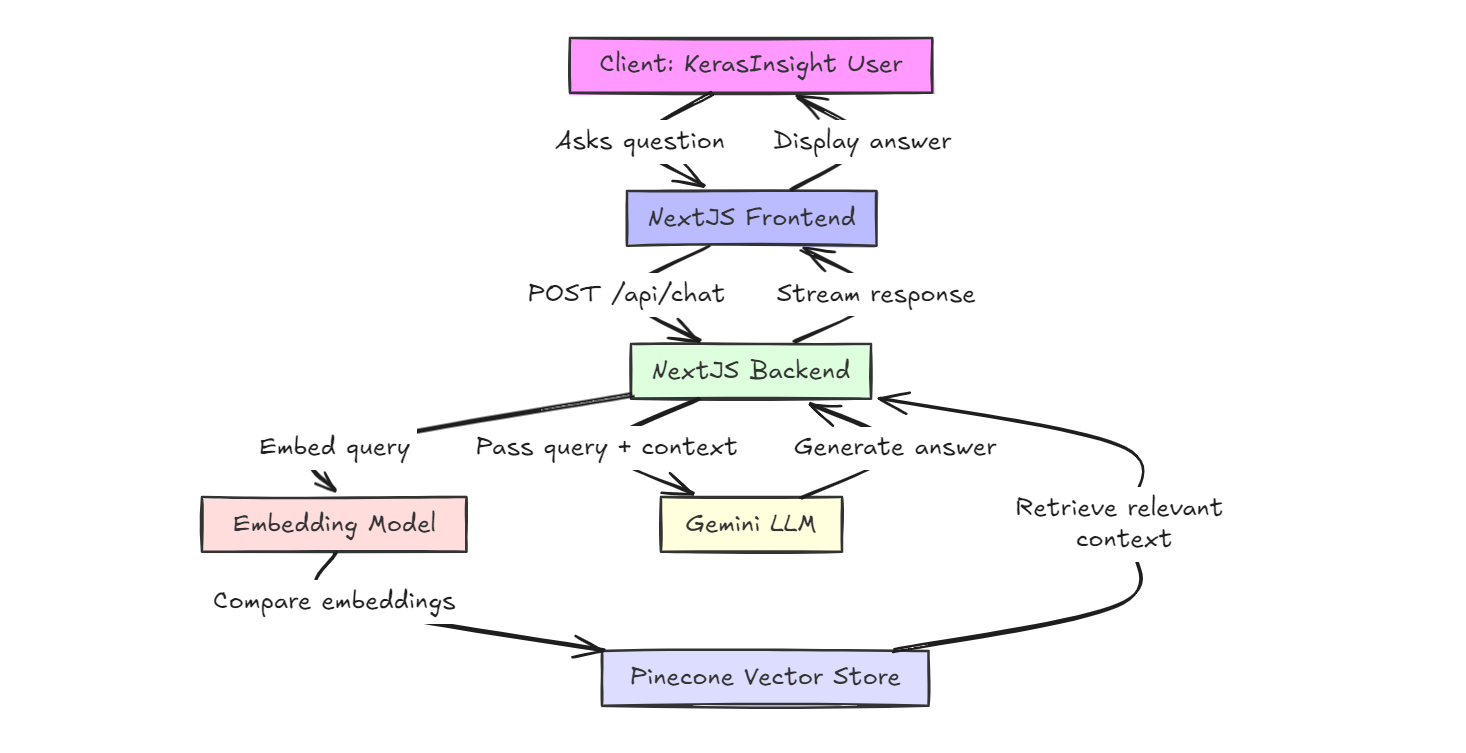
  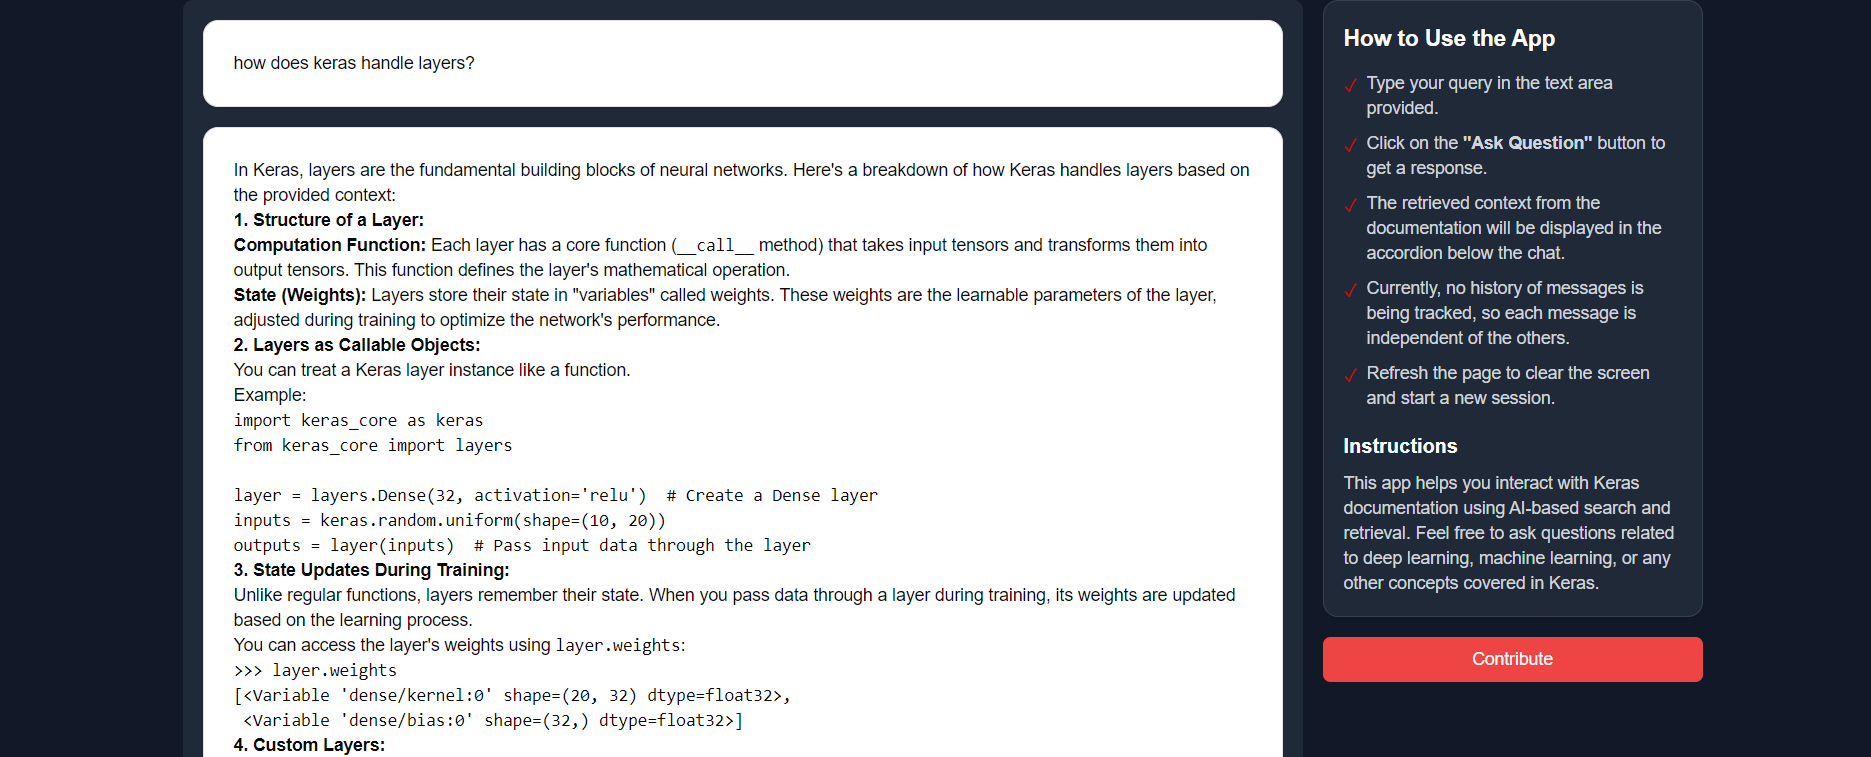
  

To allow flexibility for users to compare model outputs, I also built a **Streamlit-based app** where users can select among the four models (Gemini Fine-tuned, Gemini Pro, LLaMA, and Mixtral) and obtain answers directly from the selected model.

- **Streamlit App (Model Comparison)**:  
  The Streamlit app is live, and users can interact with different models here:  
  [Streamlit Model Comparison App](https://keras-insight-multichat-smqjfqynqvwczeep8tdzuw.streamlit.app/)
  
  Images of the application
  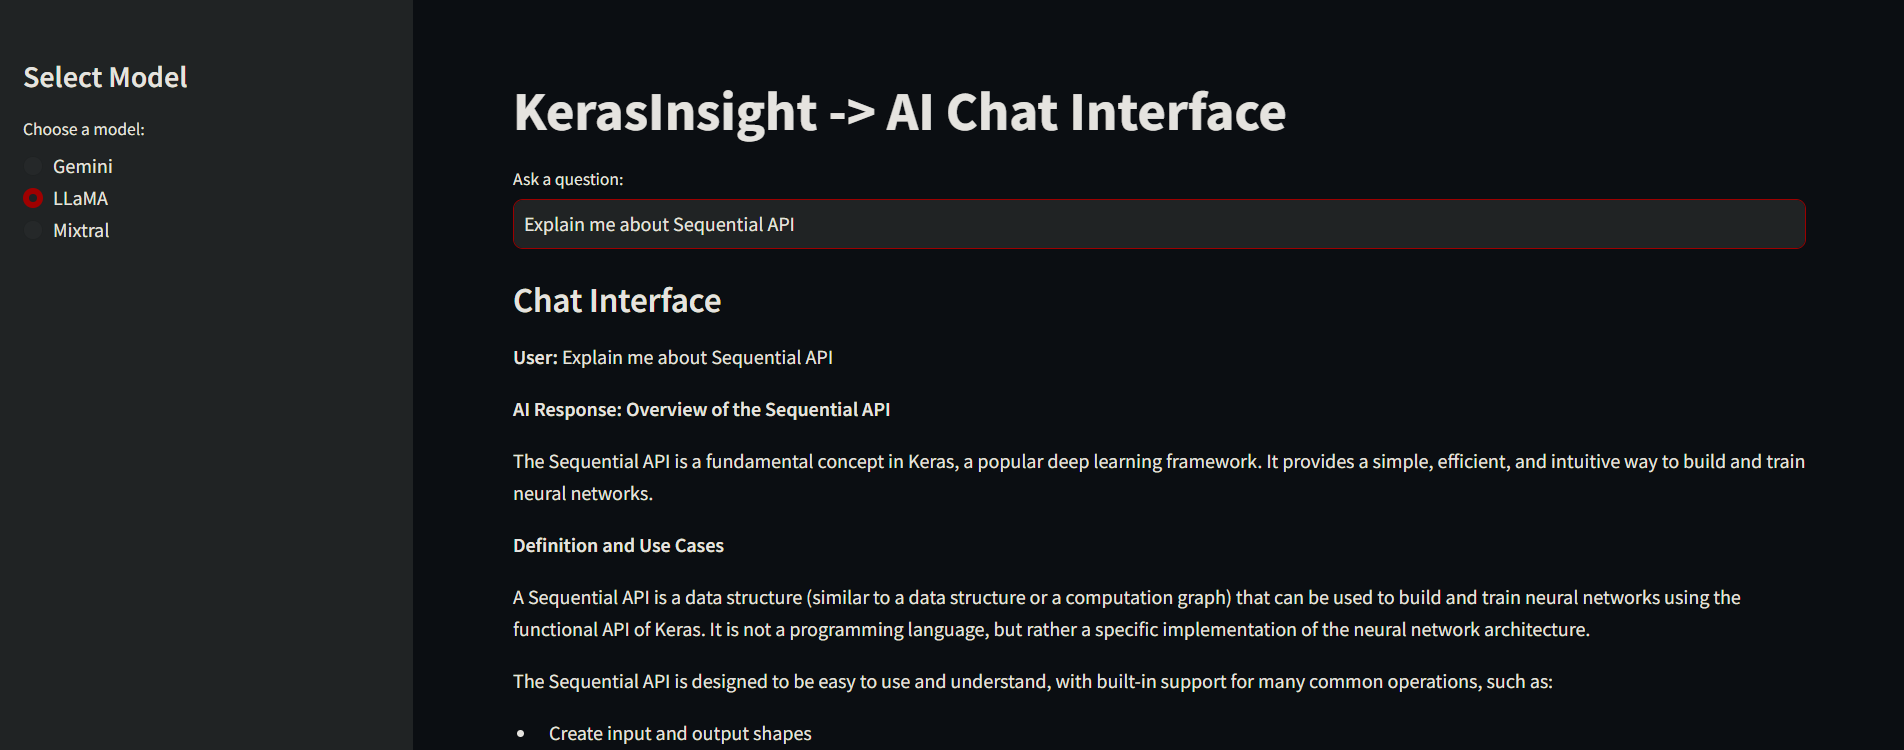

### Documentation Use Case and GitHub Repos

This project initially focused on answering questions from stable documentation, particularly **Keras** documentation, and can be considered a chatbot for **Keras Docs**. This works well for static documentation like Keras, but there are challenges with documentation that changes frequently (e.g., **Next.js** docs, **Langchain**). Since most LLMs are trained on data up to a certain year, they may provide outdated information for dynamic documentation. This was a key factor in adopting a RAG-based approach, which allows the model to remain accurate by retrieving up-to-date information.

### Expanding the Concept: **URLMind**

Based on the success of this documentation chatbot, I extended the idea to create a new project called **URLMind**. This app allows users to enter URLs of various knowledge bases they want to combine and generate a unified knowledge base. Users can then chat with the system to retrieve relevant information.

- **URLMind**:  
  [URLMind Project Deployment](https://url-mind.vercel.app/)  
  [GitHub Repo for URLMind](https://github.com/Keerthan04/URLMind)

### GitHub Repositories

For reference, here are the GitHub repositories for the projects:

- **Next.js App**:  
  [GitHub Repo for Next.js App](https://github.com/Keerthan04/Keras-Insight)
  
- **Streamlit App**:  
  [GitHub Repo for Streamlit App](https://github.com/Keerthan04/Keras-Insight-MultiChat)
